In [ ]:
import os
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
from shutil import copy2
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Add, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# separate train and test data

images_folder = "dida_test_task/images"
labels_folder = "dida_test_task/labels"

train_images_folder = "dida_test_task/train_images"
train_labels_folder = "dida_test_task/train_labels"
test_images_folder = "dida_test_task/test_images"

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)

image_files = set(os.listdir(images_folder))
label_files = set(os.listdir(labels_folder))

train_files = image_files.intersection(label_files)
test_files = image_files - train_files

for file_name in train_files:
    copy2(os.path.join(images_folder, file_name), os.path.join(train_images_folder, file_name))
    copy2(os.path.join(labels_folder, file_name), os.path.join(train_labels_folder, file_name))

for file_name in test_files:
    copy2(os.path.join(images_folder, file_name), os.path.join(test_images_folder, file_name))

print(f"Training images and labels: {len(train_files)}")
print(f"Test images: {len(test_files)}")


Training images and labels: 25
Test images: 5


#Preprocessing
 I processed images and their labels to prepare them for the training of model. It reads the images from folders, resizes them, normalizes their pixel values to a 0–1 range. Also, since we have limited data I applied augmentations such as rotation, shifting, and zooming to create more varied training data. This was crucial to improve the model’s ability to generalize, especially because the dataset is small. This increased training dataset from 25 to 150 images.

In [ ]:
# preprocessing

def augment_image_and_label(image, label):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    combined = np.concatenate([image, label], axis=-1)
    combined = np.expand_dims(combined, axis=0)

    augmented = next(datagen.flow(combined, batch_size=1))

    augmented_image = augmented[0, :, :, :3]
    augmented_label = augmented[0, :, :, 3:]

    return augmented_image, augmented_label


def load_and_preprocess_data(image_folder, label_folder=None, image_size=(128, 128), augment=False, augment_count=5):
    images = []
    labels = []

    for file_name in sorted(os.listdir(image_folder)):
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, image_size)
        img = img / 255.0

        if label_folder:
            label_path = os.path.join(label_folder, file_name)
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            label = cv2.resize(label, image_size)
            label = label / 255.0
            label = np.expand_dims(label, axis=-1)

            images.append(img)
            labels.append(label)

            if augment:
                for _ in range(augment_count):
                    aug_img, aug_label = augment_image_and_label(img, label)
                    images.append(aug_img)
                    labels.append(aug_label)
        else:
            images.append(img)

    images = np.array(images)
    labels = np.array(labels) if label_folder else None
    return images, labels


train_images, train_labels = load_and_preprocess_data(
    train_images_folder, train_labels_folder, augment=True, augment_count=5
)

test_images, _ = load_and_preprocess_data(test_images_folder)

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")


Training images shape: (150, 128, 128, 3)
Training labels shape: (150, 128, 128, 1)
Test images shape: (5, 128, 128, 3)


# Model

I implemented UNet architecture (this implementation is not identical to the original U-Net), which is a popular choice for image segmentation tasks. I searched implementations of similar tasks and saw that UNet is commonly used. The structure consists of an encoder (to extract features), a bottleneck (to capture high-level representations), and a decoder (to reconstruct the segmented output).

I chose this model because it is relatively simple and effective for segmentation tasks. While experimenting, more complex models led to underfitting, meaning they struggled to capture patterns due to insufficient data. Similarly, in my implementation I think that using ReLU activation worked better than SELU (I saw this on your article https://dida.do/blog/semantic-segmentation-of-satellite-images).

In [ ]:
# define model

def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    merge4 = concatenate([conv2, up4])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv1, up5])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_unet(input_shape=(128, 128, 3))
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 64, 64, 64)     │              0 │ conv2d_50[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 32, 32, 128)    │              0 │ conv2d_52[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_10       │ (None, 64, 64, 128)    │        131,200 │ conv2d_54[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 64, 64, 256)    │              0 │ conv2d_52[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_transpose_10[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 64, 64, 128)    │        295,040 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_55[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 128, 128, 64)   │         32,832 │ conv2d_56[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 128, 128, 128)  │              0 │ conv2d_50[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_transpose_11[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 64)   │         73,792 │ concatenate_11[0][0]   │
├──────────────────────

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

# Loss function

I used dice loss (also tried binary cross entropy loss and its combination with dice loss) but dice loss was better at handling imbalanced data and creating clear segmentation.

# Hyperparameters

This part was mostly about trying out and comparing different values for learning rate, batch size and epoch size. I could also write a loop that tries and finds best combination with greedy search, but it would increase run time.

In [ ]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + 1e-6)


In [ ]:
# Compile the model

model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])


In [ ]:
# Train the model

history = model.fit(
    train_images, train_labels,
    validation_split=0.2,
    epochs=100,
    batch_size=24,
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7938 - loss: 0.7814 - val_accuracy: 0.7133 - val_loss: 0.8135
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.4258 - loss: 0.7813 - val_accuracy: 0.0855 - val_loss: 0.8108
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.1007 - loss: 0.7758 - val_accuracy: 0.0802 - val_loss: 0.8070
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.0959 - loss: 0.7753 - val_accuracy: 0.0801 - val_loss: 0.7993
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.0967 - loss: 0.7631 - val_accuracy: 0.0801 - val_loss: 0.7860
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.0958 - loss: 0.7524 - val_accuracy: 0.0801 - val_loss: 0.7861
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.0958 - loss: 0.7495 - val_accuracy: 0.0801 - val_loss: 0.7882
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.1005 - loss: 0.7414 - val_accuracy: 0.0801 - val

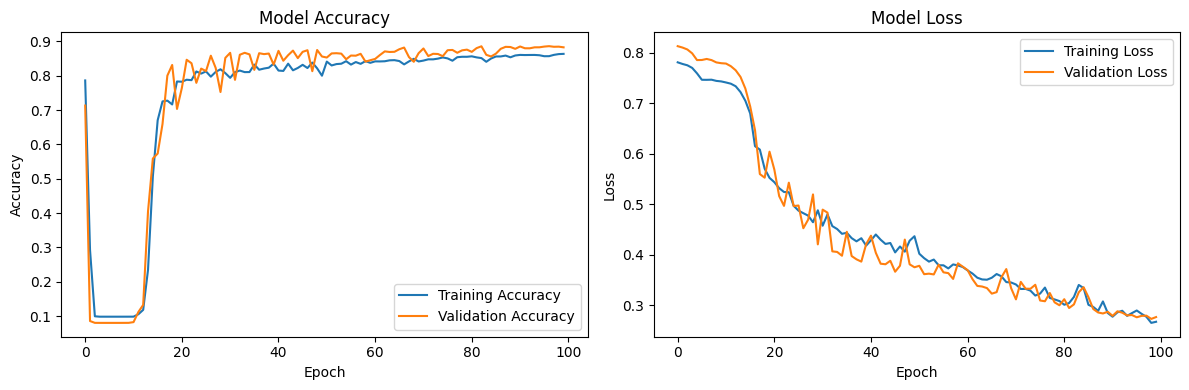

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()


In [ ]:
# Predict on test images

predictions = model.predict(test_images)

threshold = 0.5
predicted_labels = (predictions > threshold).astype(np.uint8)

print(f"Predicted labels shape: {predicted_labels.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted labels shape: (5, 128, 128, 1)


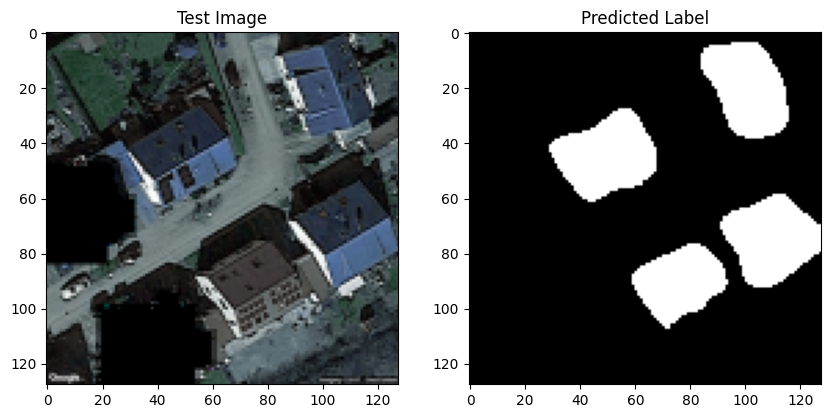

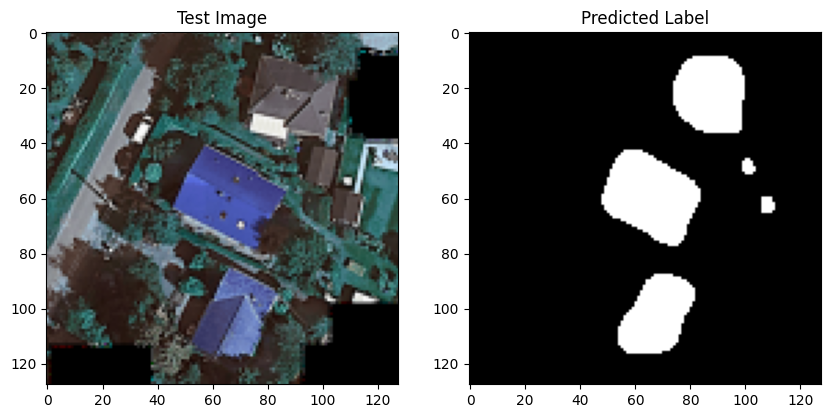

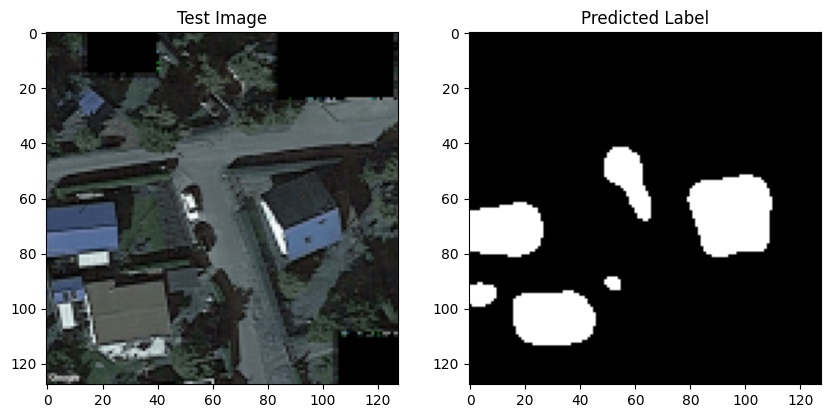

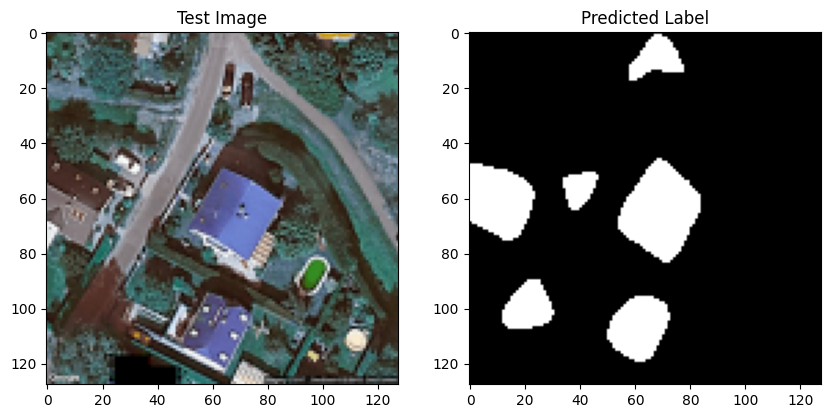

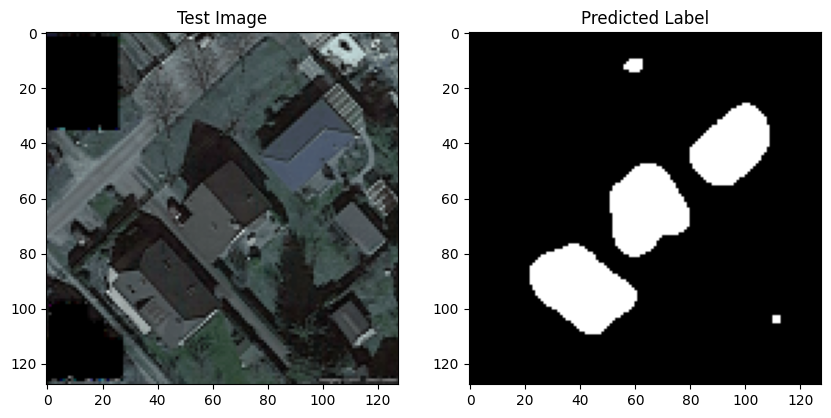

In [ ]:
for i in range(len(test_images)):
    plt.figure(figsize=(10, 5))

    # Test image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title("Test Image")

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_labels[i].squeeze(), cmap='gray')
    plt.title("Predicted Label")

    plt.show()

In [ ]:
# save predictions
output_folder = "dida_test_task/predicted_labels"
os.makedirs(output_folder, exist_ok=True)

for i, label in enumerate(predicted_labels):
    label = (label.squeeze() * 255).astype(np.uint8)

    output_path = os.path.join(output_folder, f"predicted_label_{i+1}.png")
    cv2.imwrite(output_path, label)

print(f"Predicted labels saved to: {output_folder}")

Predicted labels saved to: dida_test_task/predicted_labels
